https://archive.ics.uci.edu/dataset/222/bank+marketing

### Import

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "data3":
        # Set a seed for reproducibility
        np.random.seed(42)

        n_samples_per_class = 1000 # Total samples = 2000

        # Base mean vector
        mu = np.array([1, 1])

        # Parameters for the positive class (Y=1)
        mean_pos = 1 * mu
        cov_pos = np.array([[8, 5],
                            [5, 4]])

        # Parameters for the negative class (Y=-1)
        mean_neg = -1 * mu
        cov_neg = np.array([[1, -3],
                            [-3, 16]])


        # --- 2. Generate the data ---
        # Set a seed for reproducibility
        np.random.seed(42)

        # Generate points for each class
        X_pos = np.random.multivariate_normal(mean_pos, cov_pos, n_samples_per_class)
        y_pos = np.full(n_samples_per_class, 1) # Label for positive class is 1

        X_neg = np.random.multivariate_normal(mean_neg, cov_neg, n_samples_per_class)
        y_neg = np.full(n_samples_per_class, 0) # Label for negative class is 0


        # --- 3. Combine into a final dataset ---
        # Stack the features and labels
        X = np.vstack((X_pos, X_neg))
        y = np.hstack((y_pos, y_neg))

        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('2 Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=0.8,  # Specify 80% of the data for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    elif dataset == "BankMarketing":
        from ucimlrepo import fetch_ucirepo
        from sklearn.compose import ColumnTransformer
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
        from sklearn.model_selection import train_test_split

        # Fetch and print columns for the dataset your code is using

        # 1. Fetch data for Bank Marketing (ID 222)
        bc = fetch_ucirepo(id=222)
        X_df, y_df = bc.data.features, bc.data.targets

        # 2. Replace '?' with a standard missing value format
        X_df = X_df.replace('?', np.nan)

        # 3. Encode the target variable
        y = LabelEncoder().fit_transform(y_df.to_numpy().ravel())

        # 4. Define column lists using the correct names for this dataset
        #numeric_features = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
        #categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

        numeric_features = ['age',  'balance', 'previous']
        categorical_features = ['job',  'marital', 'poutcome']

        # 5. Create preprocessing pipelines
        numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        categorical_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # 6. Build the master preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_pipeline, numeric_features),
                ('cat', categorical_pipeline, categorical_features)
            ])

        # 7. Apply the transformations
        X = preprocessor.fit_transform(X_df)

        
        # --- CRITICAL DEBUGGING STEP ---
        print(f"Shape of X after preprocessing: {X.shape}")
        # This MUST print a shape like (286, 46). If it prints (286, 0), the preprocessor failed.
        # -----------------------------

        # 8. Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.7, random_state=42, stratify=y
        )

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

        y_train = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train
        y_test = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test


        # 9. Concatenate the data
        train_data = np.concatenate((X_train, y_train), axis=1)
        test_data = np.concatenate((X_test, y_test), axis=1)
        val_data = test_data  # For simplicity, using test data as validation data

        print(f"Shape of training data: {train_data.shape}")
        print(f"Shape of test data: {test_data.shape}")

        print("\nData successfully processed and concatenated.")
        print(f"Shape of final training data: {train_data.shape}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        #y_prob = clf_model.predict_proba(X_test)[:, 1]
        #y_pred = (y_prob >= threshold).astype(int)
        y_pred = clf_model.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

## BankMarketing: SVM regression

In [34]:
from sklearn.model_selection import KFold
import torch
import torch.utils.data as data

train_data, test_data, val_data = generate_data("BankMarketing")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)




Shape of X after preprocessing: (45211, 20)
Training data shape: (31647, 20), (31647,)
Test data shape: (13564, 20), (13564,)
Shape of training data: (31647, 21)
Shape of test data: (13564, 21)

Data successfully processed and concatenated.
Shape of final training data: (31647, 21)


### Regular training

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
# Logistic Regression
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
clf = SVC(kernel='linear', probability=True, random_state=42)  # n_processes=1 to avoid issues with multiprocessing in some environments
clf.fit(X_train, y_train)

#calculate ROC results
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
results_original_roc = {"fpr": fpr_roc, "tpr": tpr_roc, "thresholds": threshold_roc, "name": "SVM Regression", "auc": auc(fpr_roc, tpr_roc), "model": clf}



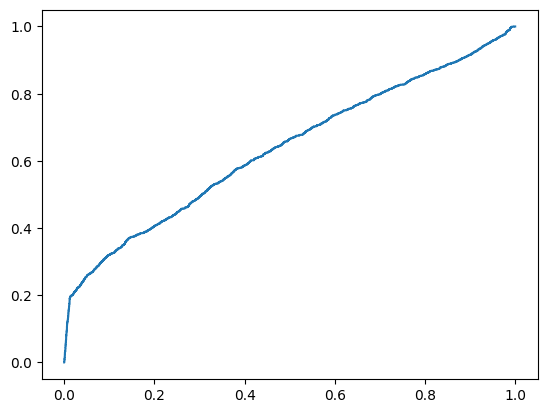

In [36]:
from matplotlib import pyplot as plt
plt.plot(fpr_roc, tpr_roc, label='SVM Regression (AUC = {:.2f})'.format(auc(fpr_roc, tpr_roc)))

## Weighted ROC curve

In [37]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from joblib import Parallel, delayed

# Assume kfold, train_data, get_fpr_tpr, get_best_roc_envelope, and results_original_roc are defined

# --- Helper function to perform the work for a single model ---
# This function will be executed in parallel for each class weight.
def train_and_evaluate_svc(w, X_train, y_train, X_test, y_test):
    """
    Trains and evaluates a single weighted SVC model.
    """
    # 1. Define class weights
    class_weights = {0: 1 - w, 1: w}

    # 2. Create and train the classifier
    clf_weighted = SVC(kernel='linear', probability=True, class_weight=class_weights, random_state=42)
    clf_weighted.fit(X_train, y_train)

    # 3. Evaluate the model
    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)
    array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(
        y_test, clf_weighted.predict_proba(X_test)[:, 1]
    )

    # 4. Package and return the results
    result = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "threshold": 0.5,
        "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
    }
    return result

# --- Main Parallel Execution Block ---

# Store the weighted classifiers and best models from all folds
list_folds_weighted_clfs = []
list_folds_best_models = []

# Define the weights to iterate over
minority_class_weight = np.arange(0.001, 0.999, 0.1)

# Outer loop for K-Fold cross-validation
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")
    
    # Prepare data for the current fold
    X_train_fold = train_data[train_ids][:, :-1]
    y_train_fold = train_data[train_ids][:, -1]
    X_test_fold = train_data[val_ids][:, :-1]
    y_test_fold = train_data[val_ids][:, -1]

    # ** PARALLEL EXECUTION of the inner loop **
    # n_jobs=-1 tells joblib to use all available CPU cores.
    list_weighted_clfs = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate_svc)(w, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
        for w in minority_class_weight
    )

    # The rest of your logic remains the same
    best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)

print("Parallel processing complete.")

--- Starting Fold 1/4 ---


--- Starting Fold 2/4 ---
--- Starting Fold 3/4 ---
--- Starting Fold 4/4 ---
Parallel processing complete.


### Store list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader

In [38]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/SVM_BankMarketing_weighted.pkl')




Data saved to pickle/SVM_BankMarketing_weighted.pkl


{'best_models': [[{'model': SVC(class_weight={0: np.float64(0.899), 1: np.float64(0.101)}, kernel='linear',
        probability=True, random_state=42),
    'fpr': np.float64(0.0),
    'tpr': np.float64(0.0021253985122210413),
    'threshold': np.float64(0.11647230517023055)},
   {'model': 'original_baseline',
    'fpr': np.float64(8.349336227769892e-05),
    'tpr': np.float64(0.002520478890989288),
    'threshold': np.float64(0.6405411441315106)},
   {'model': SVC(class_weight={0: np.float64(0.19899999999999995), 1: np.float64(0.801)},
        kernel='linear', probability=True, random_state=42),
    'fpr': np.float64(0.00014345144168698896),
    'tpr': np.float64(0.01381509032943677),
    'threshold': np.float64(0.8729094501766136)},
   {'model': SVC(class_weight={0: np.float64(0.699), 1: np.float64(0.30100000000000005)},
        kernel='linear', probability=True, random_state=42),
    'fpr': np.float64(0.00028690288337397793),
    'tpr': np.float64(0.015940488841657812),
    'threshol

# Load from pickle

In [39]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/SVM_BankMarketing_weighted.pkl')

Data loaded successfully.


### Ensemble prediction using voting

In [40]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_curve
from joblib import Parallel, delayed

# --- Helper "Worker" Function ---
# This function processes a SINGLE model and will be executed in parallel.
def get_single_model_probas(model_dict, X_test_np, test_loader, device):
    """
    Gets predicted probabilities from a single scikit-learn or PyTorch model.
    """
    model = model_dict['model']

    # --- PyTorch Model Logic ---
    if isinstance(model, nn.Module):
        model.to(device)
        model.eval()
        probas_list = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                probas = torch.sigmoid(outputs)
                probas_list.extend(probas.view(-1).cpu().numpy())
        return np.array(probas_list)

    # --- Scikit-learn Model Logic ---
    elif isinstance(model, BaseEstimator) and hasattr(model, 'predict_proba'):
        # Assumes model is already fitted
        probas = model.predict_proba(X_test_np)
        return probas[:, 1]  # Return probabilities for the positive class

    else:
        print(f"Warning: Skipping model of unsupported type: {type(model)}")
        return None  # Return None for unsupported types


# --- Main Parallelized Function ---
def predict_ensemble_and_evaluate_parallel(list_folds_best_models, test_loader):
    """
    Parallelized version: Creates an ensemble, gets predictions in parallel,
    and generates ROC curves for soft and hard voting.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Part 1: Prepare Data and Models (Same as before) ---
    all_models_flat = [model_dict for fold in list_folds_best_models for model_dict in fold]
    if not all_models_flat:
        print("Error: No models found.")
        return None, None
    print(f"Creating a single ensemble from {len(all_models_flat)} models across all folds.")

    print("Extracting full test dataset...")
    X_test_list, y_test_list = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            X_test_list.append(inputs.cpu().numpy().reshape(len(inputs), -1))
            y_test_list.append(labels.cpu().numpy())
    X_test = np.vstack(X_test_list)
    true_labels = np.concatenate(y_test_list).flatten()
    prior_prob = np.mean(true_labels)

    # --- Part 2: Get Predictions in Parallel ---
    print("Getting predictions from all models in parallel...")
    # n_jobs=-1 uses all available CPU cores. verbose=10 provides a progress bar.
    all_probas_list = Parallel(n_jobs=-1, verbose=10)(
        delayed(get_single_model_probas)(item, X_test, test_loader, device)
        for item in all_models_flat
    )

    # Filter out potential None results from unsupported models and update model list
    valid_indices = [i for i, probas in enumerate(all_probas_list) if probas is not None]
    all_probas = np.array([all_probas_list[i] for i in valid_indices])
    all_models_flat = [all_models_flat[i] for i in valid_indices]

    if all_probas.shape[0] == 0:
        print("Error: No valid predictions were generated from the models.")
        return None, None

    results = {}

    # --- Part 3: Soft Voting (Same as before) ---
    soft_vote_probas = np.mean(all_probas, axis=0)
    fpr_sv, tpr_sv, thresholds_sv = roc_curve(true_labels, soft_vote_probas)
    results['soft_voting'] = [{'fpr': f, 'tpr': t, 'threshold': th} for f, t, th in zip(fpr_sv, tpr_sv, thresholds_sv)]

    # --- Part 4: Hard Voting & Risk (Same as before) ---
    all_votes = []
    for i, probas in enumerate(all_probas):
        threshold = all_models_flat[i]['threshold']
        if isinstance(threshold, torch.Tensor):
            threshold = threshold.item()
        votes = (probas >= threshold).astype(int)
        all_votes.append(votes)

    hard_vote_scores = np.sum(np.array(all_votes), axis=0)
    fpr_hv, tpr_hv, thresholds_hv = roc_curve(true_labels, hard_vote_scores)
    results['hard_voting'] = [{'fpr': f, 'tpr': t, 'threshold': th} for f, t, th in zip(fpr_hv, tpr_hv, thresholds_hv)]
    
    mis_risk = prior_prob * (1 - tpr_hv) + (1 - prior_prob) * fpr_hv
    results['misclassification_risk'] = [{'fpr': f, 'tpr': t, 'threshold': th} for f, t, th in zip(fpr_hv, mis_risk, thresholds_hv)]
    
    return results, prior_prob

In [41]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate_parallel(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 3140 models across all folds.
Extracting full test dataset...
Getting predictions from all models in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.6s


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    4.7s
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.9s


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   10.4s


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   11.6s


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   13.1s


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 441 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  4.7min


[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed:  4.8min


[Parallel(n_jobs=-1)]: Done 842 tasks      | elapsed:  4.8min


[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:  4.8min


[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 973 tasks      | elapsed:  5.1min


[Parallel(n_jobs=-1)]: Done 1018 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1161 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1261 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1365 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1473 tasks      | elapsed:  8.8min


[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:  9.2min


[Parallel(n_jobs=-1)]: Done 1585 tasks      | elapsed:  9.3min


[Parallel(n_jobs=-1)]: Done 1642 tasks      | elapsed:  9.3min


[Parallel(n_jobs=-1)]: Done 1701 tasks      | elapsed:  9.3min


[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:  9.3min


[Parallel(n_jobs=-1)]: Done 1821 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1882 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1945 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2073 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2138 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2205 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2272 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 2341 tasks      | elapsed: 13.2min


[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed: 13.5min


[Parallel(n_jobs=-1)]: Done 2481 tasks      | elapsed: 13.6min


[Parallel(n_jobs=-1)]: Done 2552 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 2625 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 2698 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 2773 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 2848 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 2925 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 3002 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 3081 tasks      | elapsed: 17.9min


[Parallel(n_jobs=-1)]: Done 3140 out of 3140 | elapsed: 18.2min finished


## Calculate Neyman Pearson ROC curve

In [42]:
import os
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from nproc import npc
from sklearn.svm import SVC


# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

train_data, test_data, val_data = generate_data("BankMarketing")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
print("Generating constrained ROC curve (Neyman-Pearson Simulation)...")

npc_instance = npc()

model = SVC(kernel='linear', probability=True, random_state=42)

result = npc_instance.npc(
    x=X_train, 
    y=y_train, 
    method="", # Leave blank to use the provided model
    model=model,
    rand_seed=42
)

# Extract the essential, one-time results
# The structure is result[fits][split_index][element_index]
fit_results = result[0][0]
final_model = fit_results[0] # The trained model
y_test_calib = fit_results[1]       # The labels from the calibration set
y_decision_values = fit_results[2]  # The scores from the single trained model
initial_sign = fit_results[4]       # The sign indicating score direction

print("Phase 1 Complete. Model trained and scores generated.")

# --- 3. Phase 2: Calculate All ROC Points Efficiently ---
print("\nPhase 2: Calculating cutoffs for all alphas without re-training...")

# Define the FPR constraints (alphas) we want to target
alphas = np.linspace(0, 1, 51)
roc_points = []

# Get the model's scores on the completely separate test set
y_test_scores = final_model.predict_proba(X_test)[:, 1]

# If the sign is True, it means lower scores are better for class 1.
# The npc_core function expects higher scores to be better, so we invert them once.
if initial_sign:
    y_decision_values = -y_decision_values
    y_test_scores = -y_test_scores

for i, alpha in enumerate(alphas):
    # Call ONLY the fast npc_core function
    core_result = npc_instance.npc_core(
        y_test=y_test_calib,
        y_decision_values=y_decision_values,
        alpha=alpha,
        delta=0.05,
        n_cores=1
    )
    
    if not core_result or core_result[6] == True: # core_result[6] is n_small flag
        print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): No valid cutoff found (sample size may be too small).")
        continue

    # Get the optimal cutoff for this specific alpha
    cutoff = core_result[0]

    # Manually apply the cutoff to the saved scores to get predictions
    # Note: We already handled the sign, so higher score is always better here.
    y_pred = (y_test_scores >= cutoff).astype(int)

    # Calculate TPR and FPR for this point
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    current_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    roc_points.append({'fpr': current_fpr, 'tpr': current_tpr})
    print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): FPR={current_fpr:.3f}, TPR={current_tpr:.3f}")

# --- 4. Process and Plot the Results ---
# Remove duplicate points
unique_points_dict = {(p['fpr'], p['tpr']): p for p in roc_points}
constrained_points = list(unique_points_dict.values())
constrained_points = sorted(constrained_points, key=lambda x: x['fpr'])

Shape of X after preprocessing: (45211, 20)
Training data shape: (31647, 20), (31647,)
Test data shape: (13564, 20), (13564,)
Shape of training data: (31647, 21)
Shape of test data: (13564, 21)

Data successfully processed and concatenated.
Shape of final training data: (31647, 21)
Generating constrained ROC curve (Neyman-Pearson Simulation)...
Phase 1 Complete. Model trained and scores generated.

Phase 2: Calculating cutoffs for all alphas without re-training...
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.00 (1/51): No valid cutoff found (sample size may be too small).
Alpha 0.02 (2/51): FPR=0.018, TPR=0.200
Alpha 0.04 (3/51): FPR=0.038, TPR=0.221
Alpha 0.06 (4/51): FPR=0.057, TPR=0.248
Alpha 0.08 (5/51): FPR=0.076, TPR=0.274
Alpha 0.10 (6/51): FPR=0.094, TPR=0.297
Alpha 0.12 (7/51): FPR=0.117, TPR=0.329
Alpha 0.14 (8/51): FPR=0.138, TPR=0.350
Alpha 0.16 (9/51): FPR=0.158, TPR=0.376
Alpha 0.18 (10/51): FPR=0.178, TPR=0.397
Alpha 0.20 (11/51): FPR=0.196, 

In [43]:
from predict_ensemble_and_evaluate import save_to_pickle_constrained_roc

# Save the constrained ROC curve results
save_to_pickle_constrained_roc(constrained_points, filename='pickle/SVM_BankMarketing_NP_roc_curve.pkl')

Constrained ROC curve points saved to pickle/SVM_BankMarketing_NP_roc_curve.pkl


## Load NP curve pickle

In [44]:
from predict_ensemble_and_evaluate import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/SVM_BankMarketing_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/SVM_BankMarketing_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


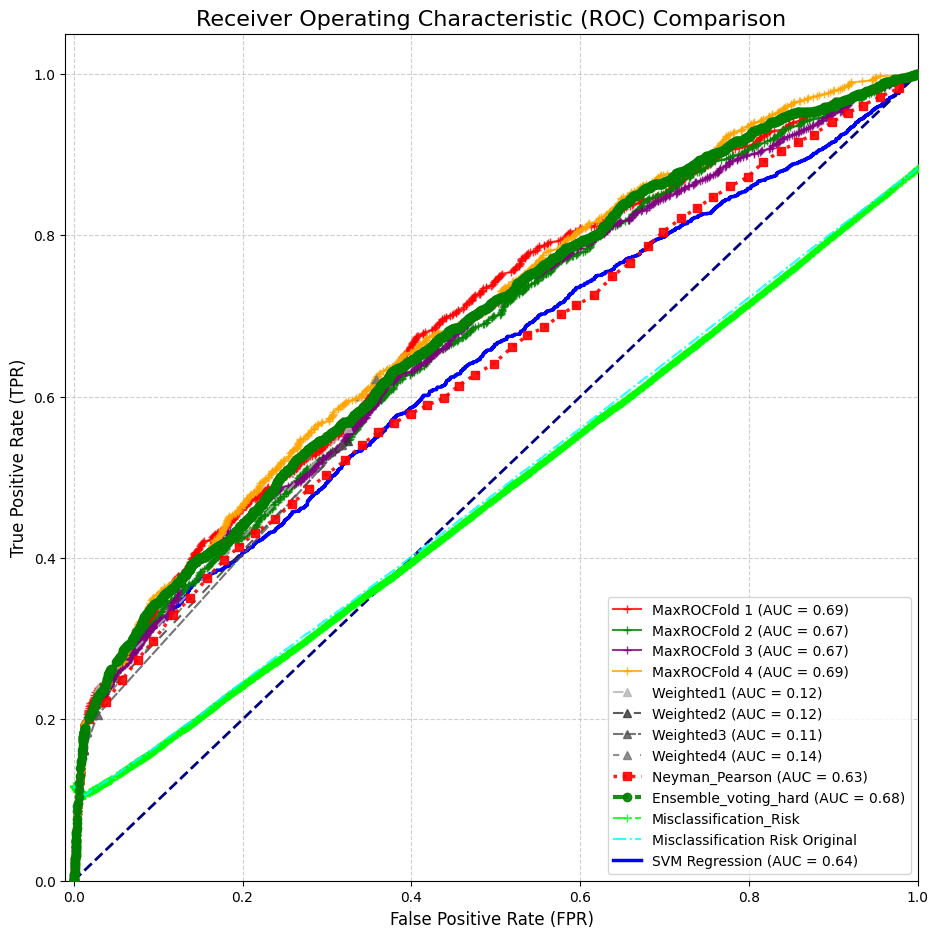

In [45]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="SVM_weighted_BankMarketing", prior_prob=prior_proba
)

## Bootstrap method

In [46]:
import numpy as np
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from joblib import Parallel, delayed

# --- Helper "Worker" Function ---
# This function contains the logic for training a SINGLE model with one weight.
# It's the "job" that will be sent to each CPU core.
def train_and_evaluate_svc(w, X_train, y_train, X_test, y_test):
    """
    Trains and evaluates a single weighted SVC model.
    """
    class_weights = {0: 1 - w, 1: w}
    clf_weighted = SVC(kernel='linear', probability=True, class_weight=class_weights, random_state=42)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)
    fprs, tprs, thresholds = roc_curve(y_test, clf_weighted.predict_proba(X_test)[:, 1])

    result = {
        "model": clf_weighted, "fpr": res["fpr"], "tpr": res["tpr"], "threshold": 0.5,
        "full_roc": {"fpr": fprs, "tpr": tprs, "thresholds": thresholds},
    }
    return result

# --- Main Execution Block ---
# Assume train_data, get_fpr_tpr, get_best_roc_envelope, and results_original_roc are defined

# Initialize lists to store results from all iterations
list_folds_weighted_clfs = []
list_folds_best_models = []

# Define parameters
minority_class_weight = np.arange(0.001, 0.999, 0.01)
n_iterations = 4  # Or any number of bootstrap iterations
n_size = int(len(train_data) * 0.75)
original_indices = np.arange(len(train_data))

# Outer loop for bootstrapping (this runs sequentially)
for ii in range(n_iterations):
    print(f"--- Starting Iteration {ii + 1}/{n_iterations} ---")

    # Bootstrap Resampling for the current iteration
    train_indices = resample(original_indices, replace=True, n_samples=n_size, random_state=ii)
    test_indices = np.setdiff1d(original_indices, np.unique(train_indices))

    X_train_fold = train_data[train_indices][:, :-1]
    y_train_fold = train_data[train_indices][:, -1]
    X_test_fold = train_data[test_indices][:, :-1]
    y_test_fold = train_data[test_indices][:, -1]
    
    # ** PARALLEL EXECUTION of the inner loop **
    # The loop over 'w' is replaced by this single Parallel call.
    # n_jobs=-1 tells joblib to use all available CPU cores.
    list_weighted_clfs = Parallel(n_jobs=-1, verbose=5)(
        delayed(train_and_evaluate_svc)(w, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
        for w in minority_class_weight
    )
    
    # The rest of your logic for the iteration remains the same
    best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)

print("\n--- Sequential processing of iterations complete ---")

--- Starting Iteration 1/4 ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 out of 100 | elapsed:  5.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.9min finished


--- Starting Iteration 2/4 ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 out of 100 | elapsed:  5.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.9min finished


--- Starting Iteration 3/4 ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 out of 100 | elapsed:  4.5min remaining:   59.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


--- Starting Iteration 4/4 ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 out of 100 | elapsed:  4.6min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished



--- Sequential processing of iterations complete ---


In [47]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/SVM_BankMarketing_weighted_bootstrap.pkl')





Data saved to pickle/SVM_BankMarketing_weighted_bootstrap.pkl


{'best_models': [[{'model': SVC(class_weight={0: np.float64(0.7090000000000001), 1: np.float64(0.291)},
        kernel='linear', probability=True, random_state=42),
    'fpr': np.float64(0.0),
    'tpr': np.float64(0.006988934187536401),
    'threshold': np.float64(0.19779119920260393)},
   {'model': SVC(class_weight={0: np.float64(0.2290000000000001),
                      1: np.float64(0.7709999999999999)},
        kernel='linear', probability=True, random_state=42),
    'fpr': np.float64(7.558578987150416e-05),
    'tpr': np.float64(0.0110658124635993),
    'threshold': np.float64(0.8885390427543364)},
   {'model': SVC(class_weight={0: np.float64(0.19900000000000018),
                      1: np.float64(0.8009999999999998)},
        kernel='linear', probability=True, random_state=42),
    'fpr': np.float64(0.00022675736961451248),
    'tpr': np.float64(0.0122306348281887),
    'threshold': np.float64(0.8765295496827404)},
   {'model': SVC(class_weight={0: np.float64(0.22900000000000

In [48]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/SVM_BankMarketing_weighted_bootstrap.pkl')

Data loaded successfully.


In [49]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate_parallel(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 5442 models across all folds.
Extracting full test dataset...
Getting predictions from all models in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   16.2s


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   19.6s


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   20.9s


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   21.2s


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 441 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1365 tasks      | elapsed:  8.5min


[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1473 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1585 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1642 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1701 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1821 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1882 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1945 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 2073 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2138 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 2205 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 2272 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 2341 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2698 tasks      | elapsed: 16.8min


[Parallel(n_jobs=-1)]: Done 2773 tasks      | elapsed: 17.1min


[Parallel(n_jobs=-1)]: Done 2848 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 2925 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 3002 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 3081 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 3241 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 3322 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 3405 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 3488 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 3573 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 3658 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 3745 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 3832 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 3921 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 4010 tasks      | elapsed: 24.8min


[Parallel(n_jobs=-1)]: Done 4101 tasks      | elapsed: 25.0min


[Parallel(n_jobs=-1)]: Done 4192 tasks      | elapsed: 25.1min


[Parallel(n_jobs=-1)]: Done 4285 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 4378 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 4473 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 4568 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 4665 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 4762 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 4861 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 4960 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 5061 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 5162 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 5265 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 5368 tasks      | elapsed: 32.5min


[Parallel(n_jobs=-1)]: Done 5442 out of 5442 | elapsed: 32.9min finished



--- Plotting all ROC curves for comparison ---


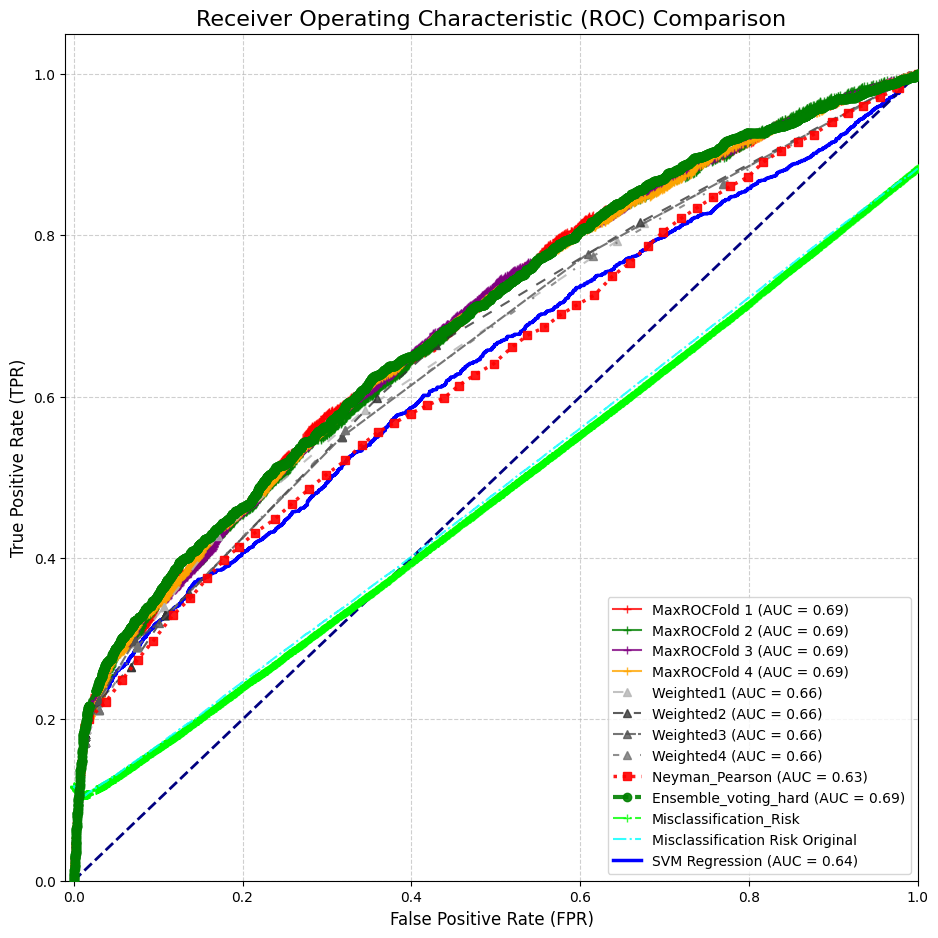

In [50]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="svm_weighted_BankMarketing_bootstrap", prior_prob=prior_proba
)